## Library Imports


In [ ]:
%load_ext autoreload
%autoreload 2
# Loading the Feature Extractor Backbone
import torchvision as tv
import torch
from torchinfo import summary
from src.models import backbone_registry as br
# Necessary to register the models
from src.models import backbones as bb
from src.models import anchors
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.data import utils as data_utils
from torchvision.utils import draw_bounding_boxes


from src.models import rpn, detector, faster_rcnn
DEVICE = "cuda"
IMAGE_DIR = "PNGImages"
MASK_DIR = "PedMasks"
ROOT = "../../data/raw/PennFudanPed"

torch.manual_seed(36)

In [ ]:
def bytes_to_gb(bytes):
    gb = bytes / (2**30)
    return gb


def bytes_to_mb(bytes):
    mb = bytes / (2**20)
    return mb


def torch_memory():
    memory_allocated = torch.cuda.memory_allocated()  # in bytes
    max_memory_allocated = torch.cuda.max_memory_allocated()  # in bytes

    # Convert to GB
    memory_allocated_gb = bytes_to_gb(memory_allocated)
    max_memory_allocated_gb = bytes_to_gb(max_memory_allocated)

    # Convert to MB
    memory_allocated_mb = bytes_to_mb(memory_allocated)
    max_memory_allocated_mb = bytes_to_mb(max_memory_allocated)

    print(
        f"Current GPU memory allocated: {memory_allocated_mb:.2f} MB ({memory_allocated_gb:.2f} GB)"
    )
    print(
        f"Peak GPU memory allocated: {max_memory_allocated_mb:.2f} MB ({max_memory_allocated_gb:.2f} GB)"
    )


def set_torch_mem_limit(fraction=0.3):
    # Print total available GPU memory before applying limit
    device = torch.cuda.current_device()
    prop = torch.cuda.get_device_properties(device)
    total_memory = prop.total_memory / 1024**3  # Convert bytes to GB
    print(f"Total available GPU memory: {total_memory:.2f} GB")

    # Set a hard limit on GPU memory usage
    torch.cuda.set_per_process_memory_fraction(fraction)

    # Print total available GPU memory after applying limit
    total_allocated = (
        torch.cuda.memory_allocated(device) / 1024**3
    )  # Convert bytes to GB
    print(
        f"Total allocated GPU memory after setting limit: {total_allocated:.2f} GB"
    )


def set_tf_mem_limit(fraction=0.3):
    # Print total available GPU memory before applying limit
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            for gpu in gpus:
                # Get the GPU device name
                print(f"GPU: {gpu.name}")

                # Print total memory available for each GPU
                gpu_memory = tf.config.experimental.get_memory_info(gpu)
                total_memory_gb = gpu_memory.total / (1024**3)
                print(f"Total GPU memory: {total_memory_gb:.2f} GB")

                # Set memory limit for each GPU
                tf.config.experimental.set_virtual_device_configuration(
                    gpu,
                    [
                        tf.config.experimental.VirtualDeviceConfiguration(
                            memory_limit=int(total_memory_gb * fraction)
                        )
                    ],
                )

                # Print memory limit after setting
                print(f"Memory limit set: {total_memory_gb*fraction:.2f} GB")
        except RuntimeError as e:
            print(e)

In [ ]:
torch_memory()

In [ ]:
0.3*24

In [ ]:
set_torch_mem_limit(0.3)

## Loading the Dataset


In [ ]:
resize_transform = v2.Compose(
    [
        v2.Resize(
            (800, 800), interpolation=v2.functional.InterpolationMode.BICUBIC
        ),
    ]
)

In [ ]:
dataset = data_utils.Masks2BboxDataset(
    root=ROOT,
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transforms=resize_transform,
)
NUM_CLASSES = 1
# Get subsets for train, validation, and test splits
train_subset = dataset.get_subset(dataset.train_indices)
valid_subset = dataset.get_subset(dataset.valid_indices)
test_subset = dataset.get_subset(dataset.test_indices)

# Create data loaders for train, validation, and test splits
train_loader = DataLoader(
    train_subset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
)
valid_loader = DataLoader(
    valid_subset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
)
test_loader = DataLoader(
    test_subset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
)

In [ ]:
data_utils.plot_batch(train_loader, batch_idx=0)

## Initial Loading


### Loading a single Image


In [ ]:
imgs, targets = zip(*train_loader)
single_img = imgs[0][0]
print(single_img.shape)
batched_single_img = single_img.float().unsqueeze(0).to("cuda")
print(batched_single_img.shape)
single_targets = targets[0][0]

In [ ]:
masks = single_targets["masks"]
gt_labels = single_targets["labels"]
gt_bboxes = single_targets["boxes"].to("cuda")

colors = [mcolors.rgb2hex(plt.get_cmap("tab10")(i)) for i in range(len(masks))]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    single_img,
    gt_bboxes,
    gt_labels,
    font=font,
    width=3,
    fill=True,
    font_size=30,
    colors=colors,
)
data_utils.plot(bbox_image)

In [ ]:
print(type(gt_bboxes[0]))

### Loading the model


In [ ]:
INPUT_SHAPE = batched_single_img.shape[1:]
BACKBONE = "VGG16"  # can be "RESNET34", "RESNET50", "RESNET101"

In [ ]:
bb_last_layer_shape, backbone, pf = br.BackBoneRegistry.create_backbone(
    BACKBONE, INPUT_SHAPE, pool_to_feature_vector=True
)
PATCH_SIZE = (
    int(INPUT_SHAPE[1] / bb_last_layer_shape[2]),
    int(INPUT_SHAPE[2] / bb_last_layer_shape[3]),
)

In [ ]:
print(f"Last Layer Shape: {bb_last_layer_shape}")
print(
    f"Single pixel in backbone feature map represents a patch of {PATCH_SIZE[0]} X {PATCH_SIZE[1]}"
)

### Initializing the Faster RCNN Model


In [ ]:
frcnn_obj = faster_rcnn.FasterRcnn(
    num_classes=1,
    backbone=backbone,
    feature_map_size=bb_last_layer_shape,
    pool_to_feature_vector=pf,
)

In [ ]:
image_shape = batched_single_img.shape[-2:]
all_anchor_bboxes, valid_anchor_bbox_indices = anchors.generate_anchor_maps(
    feature_map_size=(
        bb_last_layer_shape[-2],
        bb_last_layer_shape[-1],
    ),
    image_size=image_shape,
    ratios=[0.5, 1, 2],
    scales=[8, 16, 32],
)
all_anchor_bboxes = torch.tensor(all_anchor_bboxes, dtype = torch.float32).to(DEVICE)
valid_anchor_bbox_indices = torch.tensor(valid_anchor_bbox_indices, dtype = torch.long).to(DEVICE)
print(all_anchor_bboxes.shape, valid_anchor_bbox_indices.shape)

In [ ]:
gt_rpn_map, gt_rpn_labels = anchors.generate_rpn_map(anchor_map = all_anchor_bboxes,valid_anchor_indices = valid_anchor_bbox_indices, gt_bboxes = gt_bboxes)

In [ ]:
unique_values, counts = torch.unique(gt_rpn_labels, return_counts=True)
unique_counts = {val.item(): count.item() for val, count in zip(unique_values, counts)}
print(unique_counts)

In [ ]:
from torchvision import tv_tensors
torch_bboxes = tv_tensors.BoundingBoxes(
    all_anchor_bboxes, format="XYXY", canvas_size=v2.functional.get_size(single_img)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    single_img,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
data_utils.plot(bbox_image, subplots_kwargs={"figsize": (10, 10)})

In [ ]:
x_coor, y_coor = 400, 400
# Subtracting 8 is necessary as we generated bboxes for center of
# patches and x_coor and y_coor are the bottomright coordinates of a patch
anchrs = anchors.get_anchors_for_coordinate(
    all_anchor_bboxes, coordinate=(x_coor - 8, y_coor - 8)
)
anchrs = [anchor.cpu().numpy() for anchor in anchrs]
torch_bboxes = tv_tensors.BoundingBoxes(
    anchrs, format="XYXY", canvas_size=v2.functional.get_size(single_img)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    single_img,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
data_utils.plot(bbox_image, subplots_kwargs={"figsize": (10, 10)})

In [ ]:
fmap = backbone.to(DEVICE)(batched_single_img)

In [ ]:
rpn_obj = rpn.RPN(feature_map_size=bb_last_layer_shape, allow_edge_proposals=True)

In [ ]:
objectness_scores, bbox_deltas_map, rpn_proposals = rpn_obj(
    feature_map=fmap,
    image_shape=image_shape,
    all_anchor_bboxes=all_anchor_bboxes,
    valid_anchor_bbox_indices=valid_anchor_bbox_indices,
    max_proposals_pre_nms=12000,
    max_proposals_post_nms=2000,
)
print(objectness_scores.shape, bbox_deltas_map.shape, rpn_proposals.shape)

In [ ]:
gt_rpn_minibatch_target = faster_rcnn.FasterRcnn._sample_rpn_minibatch(gt_rpn_labels,256,0.5)

print(gt_rpn_minibatch_target.shape)
unique_values, counts = torch.unique(gt_rpn_labels, return_counts=True)
unique_counts = {val.item(): count.item() for val, count in zip(unique_values, counts)}
print(unique_counts)

unique_values, counts = torch.unique(gt_rpn_minibatch_target, return_counts=True)
unique_counts = {val.item(): count.item() for val, count in zip(unique_values, counts)}
print(unique_counts)

In [ ]:
anchrs = [anchor.detach().cpu().numpy() for anchor in rpn_proposals.squeeze()]
torch_bboxes = tv_tensors.BoundingBoxes(
    anchrs, format="XYXY", canvas_size=v2.functional.get_size(single_img)
)

colors = [
    mcolors.rgb2hex(plt.get_cmap("tab20")(i)) for i in range(len(torch_bboxes))
]
font = "/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf"
bbox_image = draw_bounding_boxes(
    single_img,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    colors=colors,
)
data_utils.plot(bbox_image, subplots_kwargs={"figsize": (10, 10)})

In [ ]:
proposals, gt_classes, gt_box_deltas = faster_rcnn.FasterRcnn._label_proposals(proposals=rpn_proposals, gt_boxes=single_targets, min_background_iou_threshold=0.0, min_object_iou_threshold=0.5)

proposals, gt_classes, gt_box_deltas = faster_rcnn.FasterRcnn._sample_proposals(
            proposals=proposals,
            gt_classes=gt_classes,
            gt_box_deltas=gt_box_deltas,
            max_proposals=128,
            positive_fraction=0.25,)

In [ ]:
gt_rpn_minibatch_target>0

In [ ]:
detector_obj = detector.Detector(
    num_classes=NUM_CLASSES,
    pool_to_feature_vector=pf,
    bb_last_layer_shape=bb_last_layer_shape,
    sampling_scale=16.0,
)

In [ ]:
detector_classes, detector_box_deltas = detector_obj(feature_map=fmap, proposals=rpn_proposals)


In [ ]:
detector_classes.shape, detector_box_deltas.shape

In [ ]:
proposals.shape, gt_classes.shape, gt_box_deltas.shape

In [ ]:
proposals.shape, gt_classes.shape, gt_box_deltas.shape

In [ ]:
colors = [mcolors.rgb2hex(plt.get_cmap("tab10")(i)) for i in range(len(gt_classes))]

In [ ]:
torch_bboxes = tv_tensors.BoundingBoxes(
    proposals, format="XYXY", canvas_size=v2.functional.get_size(single_img)
)

In [ ]:
proposals.shape

In [ ]:
gt_classes

In [ ]:

sample_proposals_bbox_image = draw_bounding_boxes(
    single_img,
    torch_bboxes,
    font=font,
    width=3,
    fill=False,
    font_size=30,
    labels=gt_classes,
    colors=colors,
)

In [ ]:
proposals.shape, gt_classes.shape, gt_box_deltas.shape

In [ ]:
objectness_scores.shape, gt_rpn_minibatch_target.shape

In [ ]:
rpn_class_loss = rpn.class_loss(predicted_scores=objectness_scores, objectness_score_target=gt_rpn_minibatch_target)


In [ ]:
rpn_reg_loss = rpn.regression_loss(predicted_box_deltas=bbox_deltas_map, box_deltas_target=gt_rpn_map.unsqueeze(dim = 0), objectness_score_target=gt_rpn_minibatch_target)

In [ ]:
detector_classes.shape, gt_classes.shape, gt_box_deltas.shape, detector_box_deltas.shape

In [ ]:
detector_class_loss = detector.regression_loss(predicted_box_deltas=detector_classes,y_true=gt_box_deltas)

In [ ]:
detector_class_loss = detector.class_loss(predicted_classes=detector_classes,y_true=gt_classes)

- NOTES:
  - Don't forget to send the image data and feature extractor to a device
  - Also image data should be converted to floats
- Feature map size = [1,512,50,50]
  - Used in generating anchors # Should be 50, 50
  - Used in RPN, for feature map channel count # Should be 1,512,50,50

- Image_data:
  - Used in FasterRcnn forward pass # Should be 1,3,800,800
  - Used in FasterRcnn predict meth # Should be 1,3,800,800


- FasterRcnn:
  - all_anchor_bboxes: forward: Bboxes of shape (22500(H*W*A), 4(y1x1y2x2)), A = 9, H,W of feature_map i.e. 50
  - anchor_valid_indices: forward: Valid bbox indexes out of all_anchor_bboxes i.e., the ones which don't go outside the image. (len(Valid_indices,),)
  - image_data: forward: [bs,C,H,W]


## Rough


In [ ]:
df = df.dropna()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def plot(df, save_filename, col_name, plot_title):
    df = df.dropna()
    # Set the style to have only horizontal grid lines
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

    # Generate error values as a percentage of the values (e.g., 10%)
    error_percentage = 0.1
    errors = df[f"{col_name}"] * error_percentage

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the bar plot with Seaborn
    sns.barplot(
        x=df["Sample_number"],
        y=df[f"{col_name}"],
        ax=ax,
        errorbar=None,
        edgecolor="black",
        color="#0099ff",
        width=0.6,  # Adjust the width of the bars here
    )

    # Add error bars
    ax.errorbar(
        df["Sample_number"],
        df[f"{col_name}"],
        yerr=errors,
        fmt="none",
        c="black",
        capsize=5,
    )

    # Set labels and title
    ax.set_xlabel("Sample number")
    ax.set_ylabel("DNA copies per gms")
    ax.set_title(f"{plot_title}")
    plt.xticks(rotation=90)

    # Format y-axis in scientific notation with custom format
    formatter = FuncFormatter(lambda x, _: f"{x:.2e}")
    ax.yaxis.set_major_formatter(formatter)

    # Show only horizontal grid lines
    ax.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5)
    ax.grid(False, which="major", axis="x")

    # Show the plot
    plt.tight_layout()
    plt.savefig(save_filename, dpi=150, bbox_inches="tight")
    plt.show()

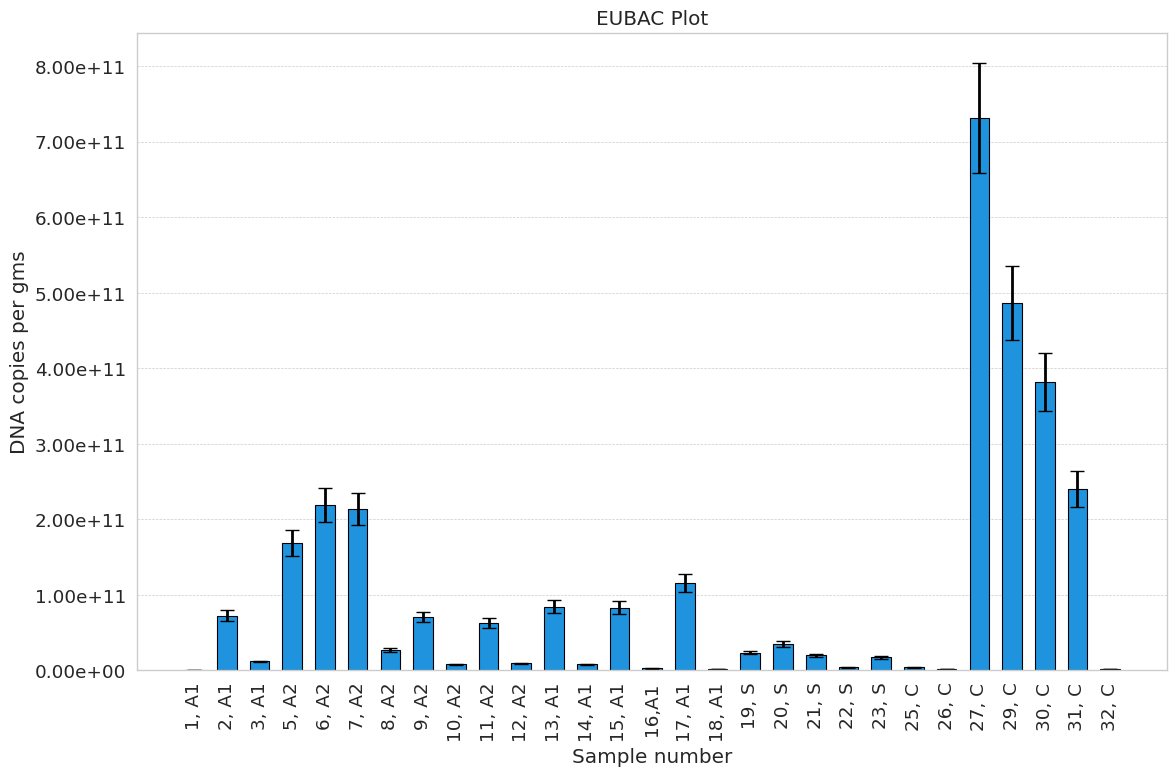

In [6]:
df = pd.read_csv("../../rough/Average_AUBAC.csv")
# Call the function with the DataFrame and desired save filename
plot(df, "EUBAC_plot.png", col_name="Avg_EUBAC", plot_title="EUBAC Plot")

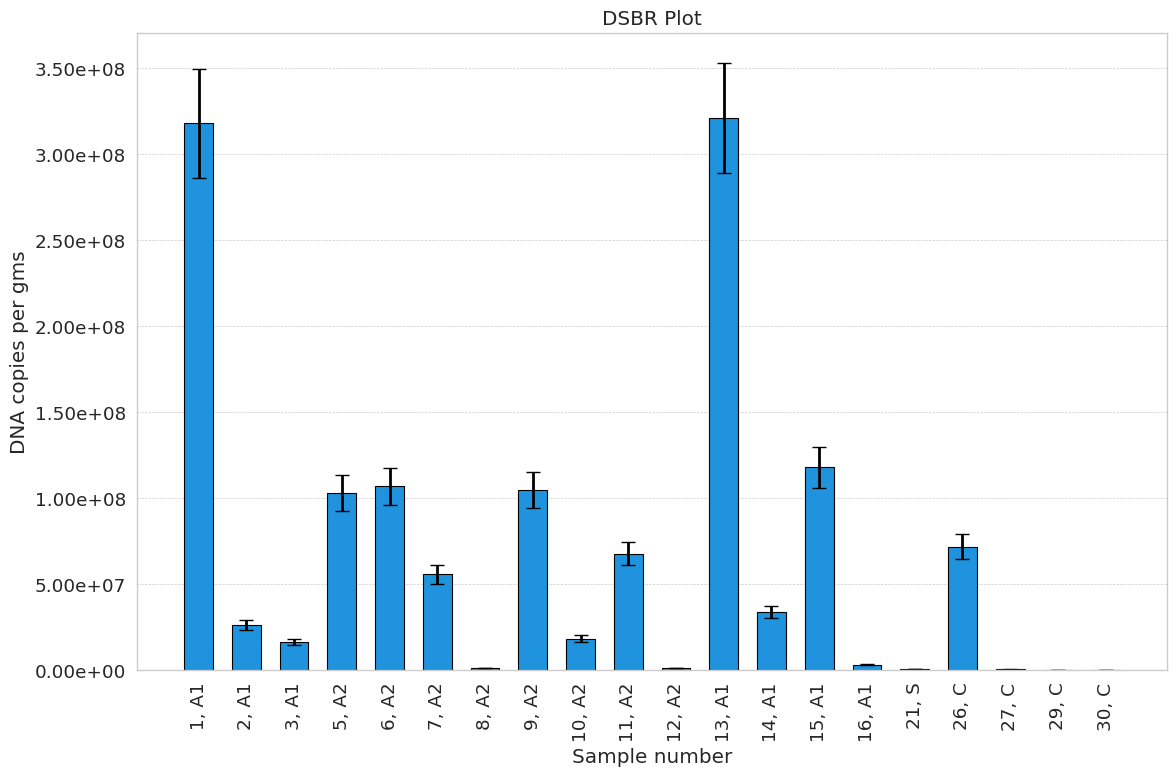

In [7]:
df = pd.read_csv("../../rough/Average_DSBR.csv")
# Call the function with the DataFrame and desired save filename
plot(df, "DSBR_plot.png", "Avg_DSBR", "DSBR Plot")

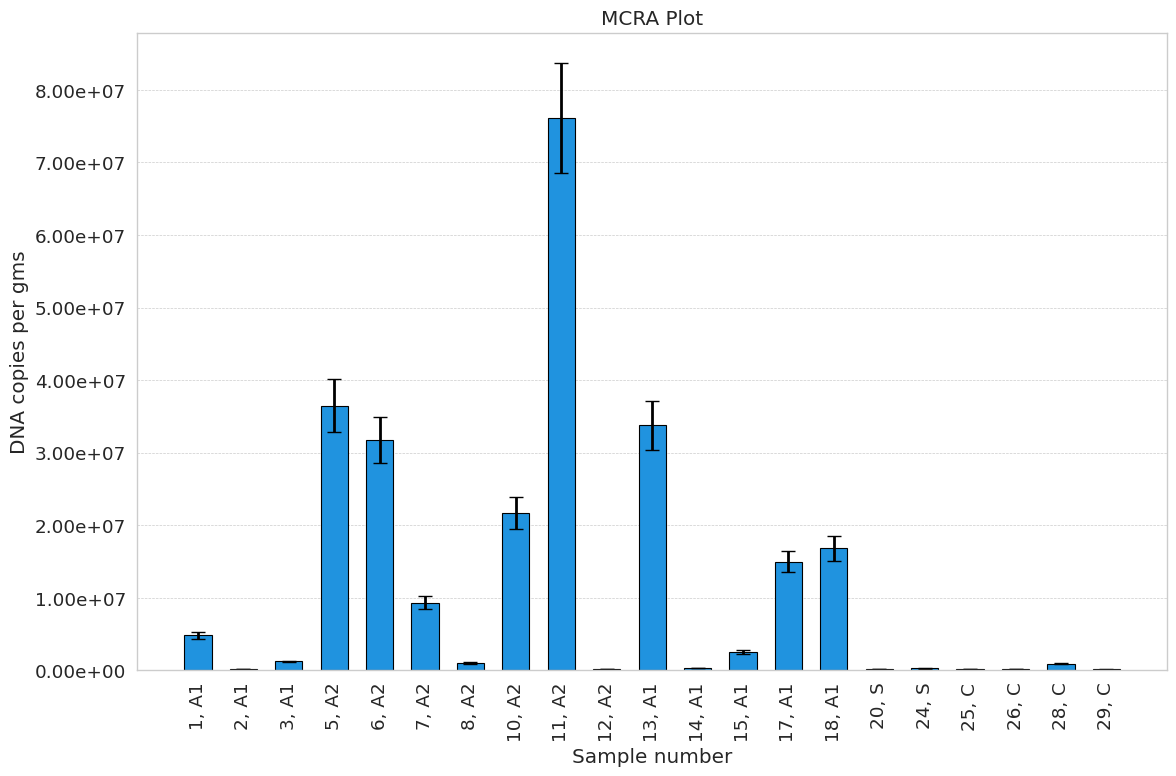

In [8]:
df = pd.read_csv("../../rough/Average_MCRA.csv")
# Call the function with the DataFrame and desired save filename
plot(df, "MCRA_plot.png", "Avg_MCRA", "MCRA Plot")

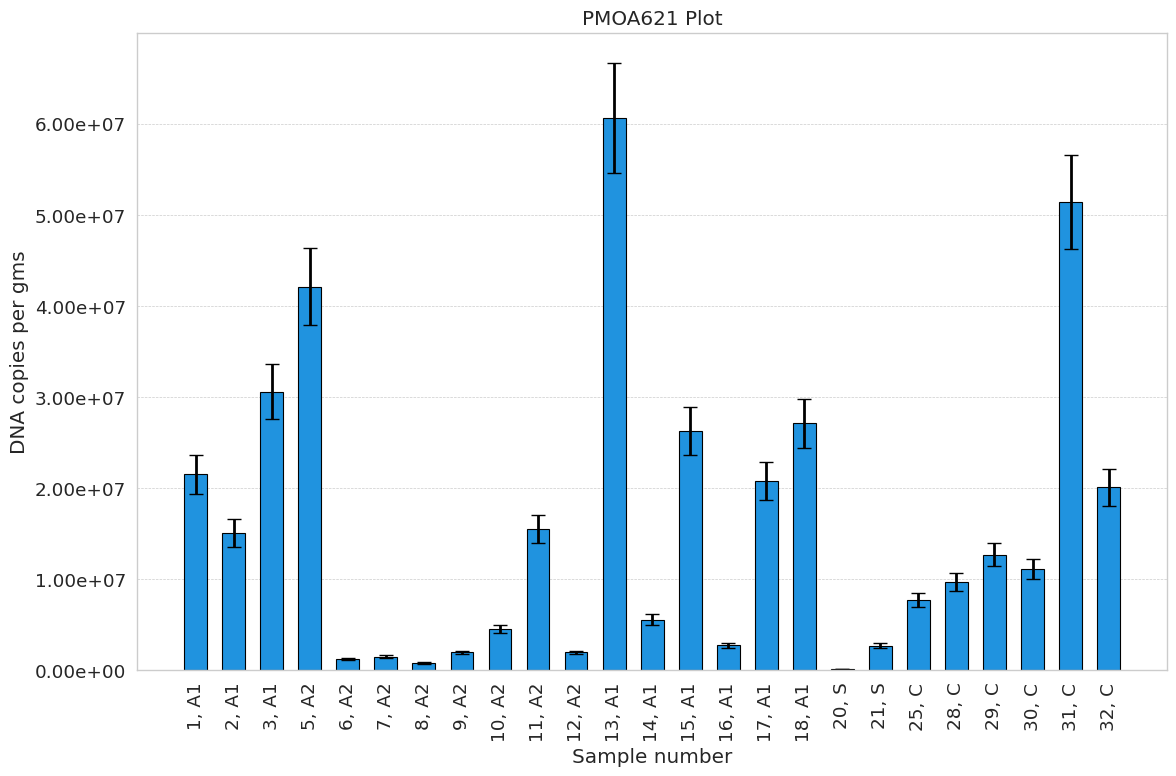

In [9]:
df = pd.read_csv("../../rough/Average_PMOA621.csv")
# Call the function with the DataFrame and desired save filename
plot(df, "PMOA621_plot.png", "Avg_PMOA621", "PMOA621 Plot")

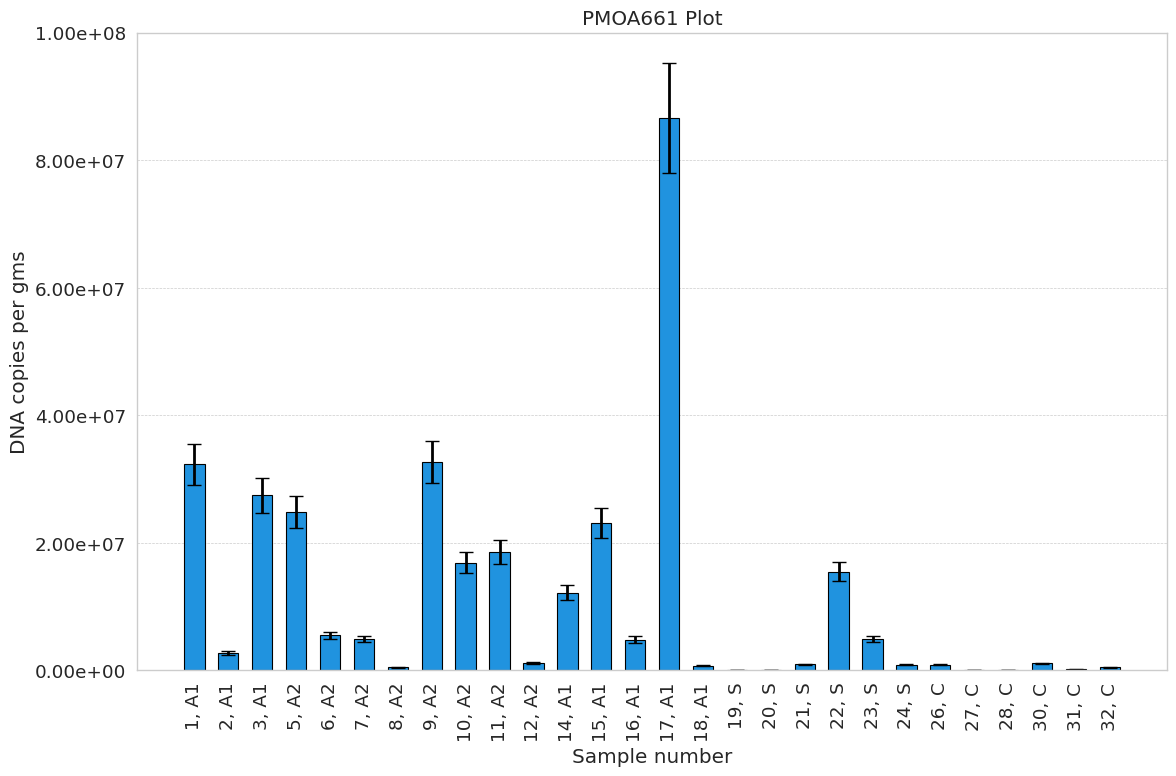

In [10]:
df = pd.read_csv("../../rough/Average_PMOA661.csv")
# Call the function with the DataFrame and desired save filename
plot(df, "PMOA661_plot.png", "Avg_PMOA661", "PMOA661 Plot")